##**Import Library**##

Import beberapa library yang diperlukan untuk analisa data, visualisasi data dan melatih model

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV




##**Data Loading**##

In [150]:
data_path = '/content/SOL-USD.csv'

df = pd.read_csv(data_path)
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-10,0.832005,1.313487,0.694187,0.951054,0.951054,87364276
1,2020-04-11,0.951054,1.049073,0.765020,0.776819,0.776819,43862444
2,2020-04-12,0.785448,0.956670,0.762426,0.882507,0.882507,38736897
3,2020-04-13,0.890760,0.891603,0.773976,0.777832,0.777832,18211285
4,2020-04-14,0.777832,0.796472,0.628169,0.661925,0.661925,16747614
...,...,...,...,...,...,...,...
710,2022-03-21,88.605003,91.011986,87.207642,88.757202,88.757202,1598537312
711,2022-03-22,88.741905,93.766808,88.182777,90.512970,90.512970,1879747152
712,2022-03-23,90.513931,96.051842,89.811462,95.102684,95.102684,2099467745
713,2022-03-24,95.020905,103.455795,94.065506,102.223694,102.223694,3601646600


#**Cek Informasi Pada Data**#

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       715 non-null    object 
 1   Open       715 non-null    float64
 2   High       715 non-null    float64
 3   Low        715 non-null    float64
 4   Close      715 non-null    float64
 5   Adj Close  715 non-null    float64
 6   Volume     715 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 39.2+ KB


Dapat dilihat bahwa tidak terdapat missing value pada dataset

In [152]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,715.000000,715.000000,715.000000,715.000000,715.000000,7.150000e+02
mean,54.051012,56.774647,51.320087,54.153403,54.153403,1.060786e+09
std,69.460225,72.374773,66.161465,69.384202,69.384202,1.668713e+09
min,0.513391,0.559759,0.505194,0.515273,0.515273,6.520200e+05
25%,2.030308,2.204544,1.909757,2.037599,2.037599,1.199775e+07
50%,19.415682,20.869474,18.891403,19.810223,19.810223,2.611757e+08
75%,91.939106,96.126831,88.567947,92.328099,92.328099,1.821714e+09
max,258.781555,260.062103,246.122421,258.934326,258.934326,1.706864e+10


Dapat dilihat pada visualisasi data dibawah. Terdapat banyak data outlier pada numerik yaitu price, open, high, low.

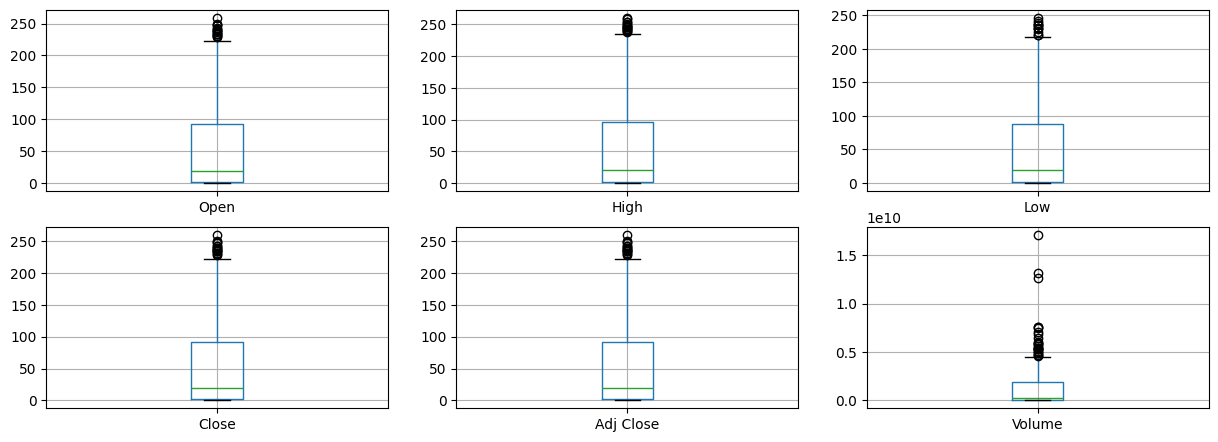

In [153]:

numeric_features = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 8))

for i, col in enumerate(numeric_features):
  plt.subplot(3,3,i+1)
  df.boxplot(column=col)

menerapkan teknik IQR Method yaitu dengan menghapus data yang berada diluar interquartile range. Interquartile merupakan range diantara kuartil pertama(25%) dan kuartil ketiga(75%).

In [154]:
# Convert 'Date' to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Exclude non-numeric columns before calculating quantiles
numeric_df = df.select_dtypes(include=np.number)

Q1 = numeric_df.quantile(.25)
Q3 = numeric_df.quantile(.75)

IQR = Q3 - Q1

bot_treshold = Q1 - 1.5 * IQR
top_treshold = Q3 + 1.5 * IQR

# Apply the filtering on the original dataframe
df = df[~((numeric_df < bot_treshold) | (numeric_df > top_treshold)).any(axis=1)]
df.shape

(672, 7)

Jika di lihat dari visualisasi data dibawah. Fitur Close pada sumbu y memiliki korelasi dengan data pada fitur High, Low, Open

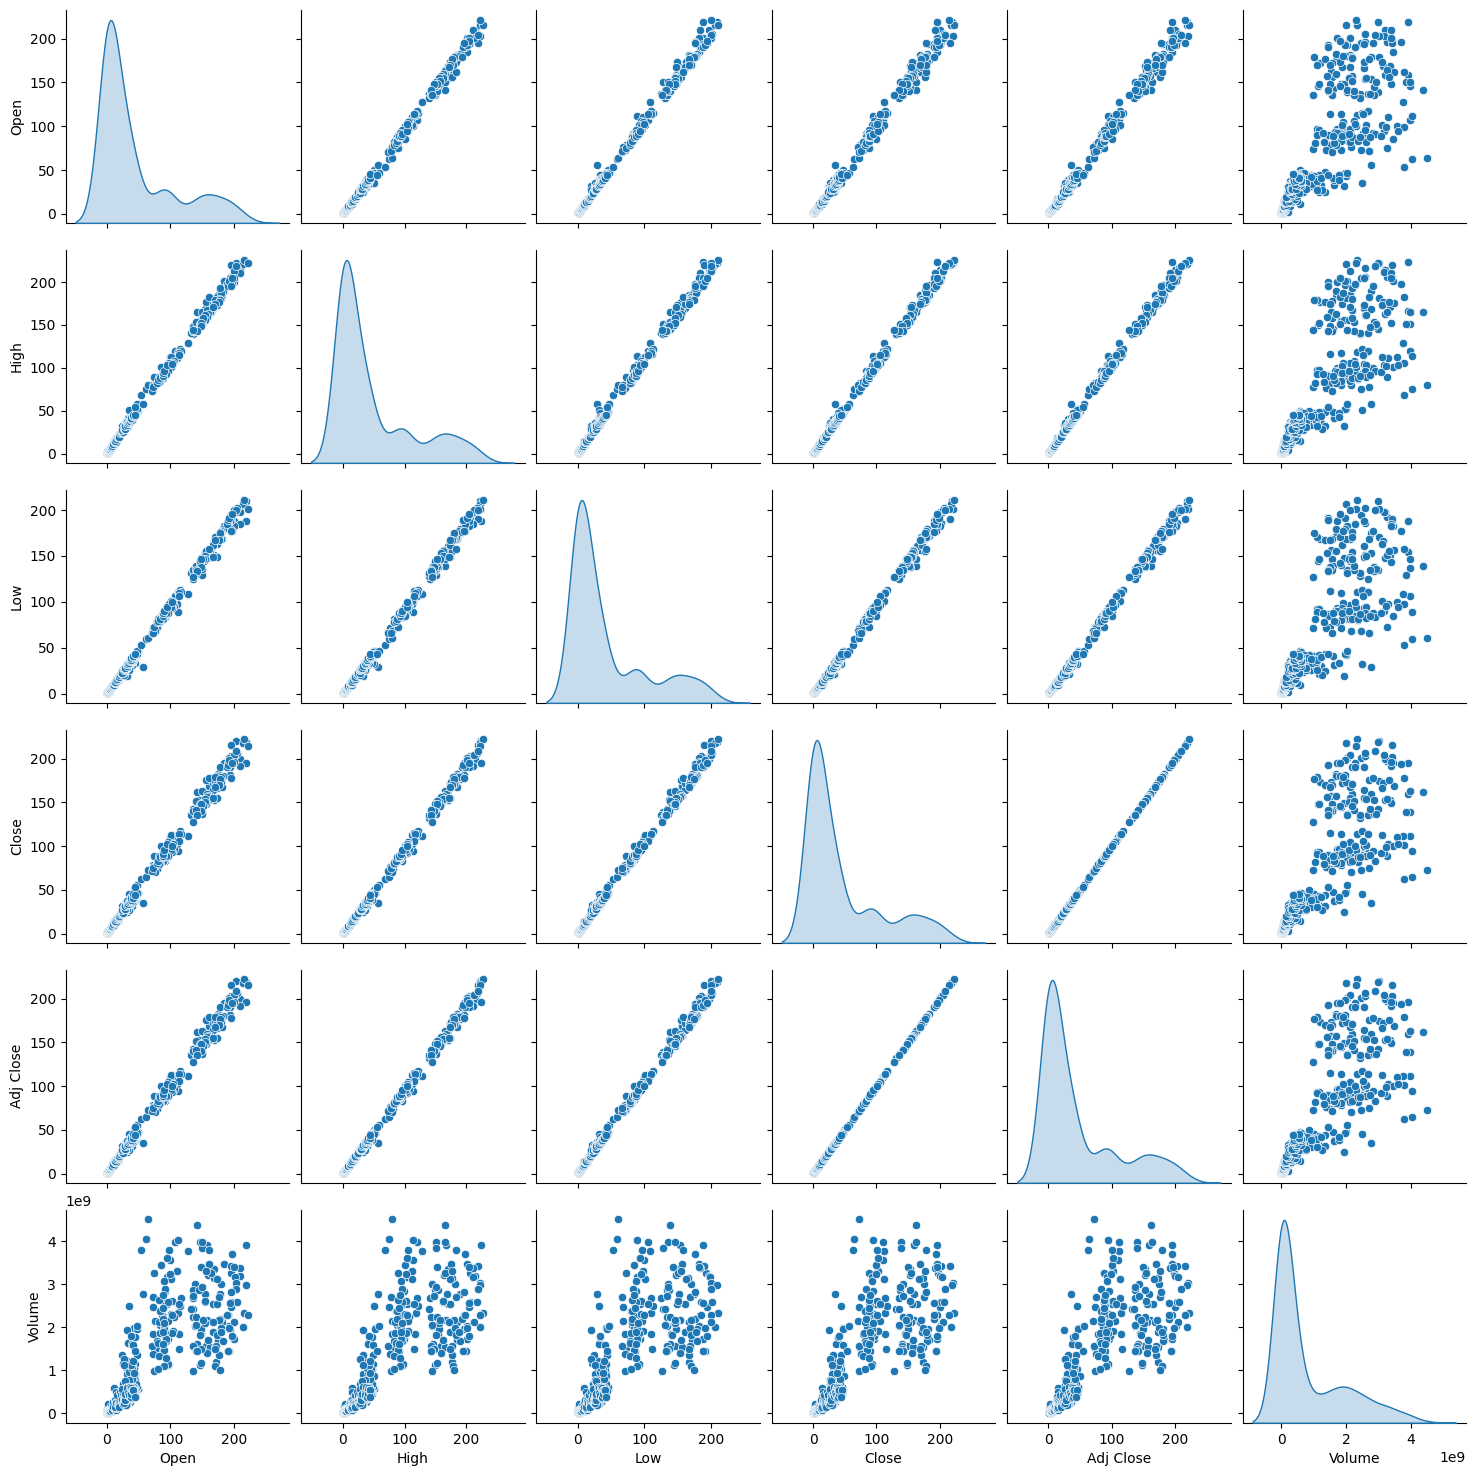

In [155]:
sns.pairplot(df, diag_kind = 'kde')
plt.show()

##**Data Preparation**##

Kolom data seperti ( Date, vol, adj close) tidak diperlukan untuk pelatihan, karena data tersebut akan mengganggu model dalam mempelajari data. Karena isi dari data tersebut tidak memiliki value yang berarti untuk dipelajari oleh model. Lalu, mengubah nama kolom High, Low, Open, Close menjadi nama kolom yang dapat lebih dipahami.

In [156]:
unused_columns = ['Date', 'Volume', 'Adj Close']
renamed_columns = {'High': 'High_Price', 'Low': 'Low_Price',
                   'Open': 'Open_Price', 'Close': 'Close_Price'}

df.drop(unused_columns, axis=1, inplace=True)
df.rename(columns=renamed_columns, inplace=True)
df

<ipython-input-156-604eedb6912c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(unused_columns, axis=1, inplace=True)
<ipython-input-156-604eedb6912c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=renamed_columns, inplace=True)


,Open_Price,High_Price,Low_Price,Close_Price
0,0.832005,1.313487,0.694187,0.951054
1,0.951054,1.049073,0.765020,0.776819
2,0.785448,0.956670,0.762426,0.882507
3,0.890760,0.891603,0.773976,0.777832
4,0.777832,0.796472,0.628169,0.661925
...,...,...,...,...
710,88.605003,91.011986,87.207642,88.757202
711,88.741905,93.766808,88.182777,90.512970
712,90.513931,96.051842,89.811462,95.102684
713,95.020905,103.455795,94.065506,102.223694


##**Split dataset**##

Membagi dataset menjadi data training dan data testing

In [157]:
x = df.drop(['Close_Price'], axis=1).values
y = df['Close_Price'].values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1)

print(f'Total # of sample in whole dataset: {len(x)}')
print(f'Total # of sample in train dataset: {len(x_train)}')
print(f'Total # of sample in test dataset: {len(x_test)}')

Total # of sample in whole dataset: 672
Total # of sample in train dataset: 537
Total # of sample in test dataset: 135


##**Normalisasi data**##

MinMaxScaler mentransformasikan fitur dengan menskalakan setiap fitur ke rentang tertentu. Library ini menskalakan dan mentransformasikan setiap fitur secara individual sehingga berada dalam rentang yang diberikan pada set pelatihan, pada library ini memiliki range default antara nol dan satu.

In [158]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)

In [159]:
models = pd.DataFrame(columns=['train_mse', 'test_mse'],
                      index=['KNN', 'RandomForest', 'SVR', 'XGboost'])

##**Model Development**##

Untuk melakukan tuning hyperparameter pada proyek ini menggunakan teknik Grid search. Grid search memungkinkan untuk menguji beberapa parameter sekaligus pada sebuah model.

In [160]:
svr = SVR()
parameters = {
    'kernel': ['rbf'],
    'C':     [1000, 10000, 100000],
    'gamma': [0.3, 0.03, 0.003]
}

svr_search = GridSearchCV(
    svr,
    parameters,
    cv=5,
    verbose=1,
    n_jobs=6,
)

svr_search.fit(x_train, y_train)
svr_best_params = svr_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [161]:
knn = KNeighborsRegressor()
parameters =  {
    'n_neighbors': range(1, 25),
}

knn_search = GridSearchCV(
  knn,
  parameters,
  cv=5,
  verbose=1,
  n_jobs=6,
)

knn_search.fit(x_train, y_train)
knn_best_params = knn_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [162]:
rf = RandomForestRegressor()
parameters =  {
    'n_estimators': range(1, 10),
    'max_depth': [16, 32, 64],
}

rf_search = GridSearchCV(
  rf,
  parameters,
  cv=5,
  verbose=1,
  n_jobs=6,
)
rf_search.fit(x_train, y_train)
rf_best_params = rf_search.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [163]:
xgb_model = xgb.XGBRegressor()
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_search = GridSearchCV(
    xgb_model,
    parameters,
    cv=5,
    verbose=1,
    n_jobs=6,
)
xgb_search.fit(x_train, y_train)
xgb_best_params = xgb_search.best_params_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


##**Training Model**##

**Support Vector Machine**

In [164]:
svr = SVR(
  C=svr_best_params["C"],
  gamma=svr_best_params["gamma"],
  kernel=svr_best_params['kernel']
)
svr.fit(x_train, y_train)

SVR(C=100000, gamma=0.3)

**K-Nearest Neighbours**

In [165]:
knn = KNeighborsRegressor(n_neighbors=knn_best_params["n_neighbors"])
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=3)

**Random Forest**

In [166]:
rf = RandomForestRegressor(
  n_estimators=rf_best_params["n_estimators"],
  max_depth=rf_best_params["max_depth"]
)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=16, n_estimators=9)

**Gradient Boosting Machines (XGBoost)**

In [167]:
xgb_model = xgb.XGBRegressor(
    **xgb_best_params
)
xgb_model.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##**Model Evaluation**##

In [168]:
x_test = scaler.transform(x_test)

In [169]:
model_dict = {'KNN': knn, 'RandomForest': rf, 'SVR': svr, 'XGboost' : xgb_model}

for name, model in model_dict.items():
  models.loc[name, 'train_mse'] = mean_squared_error(
    y_true=y_train,
    y_pred=model.predict(x_train)
  )
  models.loc[name, 'test_mse'] = mean_squared_error(
    y_true=y_test,
    y_pred=model.predict(x_test)
  )

models

,train_mse,test_mse
KNN,3.021424,11.21814
RandomForest,1.329406,8.439481
SVR,2.658784,5.582168
XGboost,0.611823,9.816996


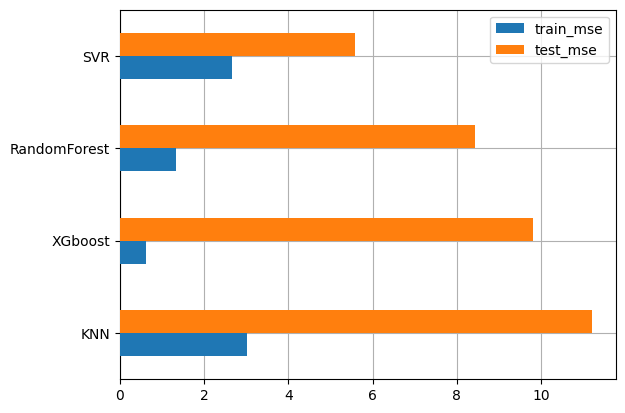

In [170]:
fig, ax = plt.subplots()
models.sort_values(by='test_mse', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [171]:
test_data = x_test.copy()
predictions = {'y_true':y_test}
for name, model in model_dict.items():
  predictions['prediction_' + name] = model.predict(test_data)

predictions = pd.DataFrame(predictions)
predictions


,y_true,prediction_KNN,prediction_RandomForest,prediction_SVR,prediction_XGboost
0,1.565110,1.384554,1.364389,1.539797,1.410428
1,42.308376,40.964269,41.272459,42.087246,40.984459
2,1.686807,1.713185,1.718880,1.720847,1.749326
3,199.807251,206.414449,205.393602,206.900639,203.123672
4,0.668313,0.643414,0.641414,0.646627,0.676477
...,...,...,...,...,...
130,2.665228,2.450286,2.574141,2.524144,2.684482
131,0.579415,0.583231,0.583488,0.563853,0.663808
132,164.115829,165.406743,158.681157,164.019918,160.982147
133,1.911828,1.927058,1.940444,1.865579,1.945492


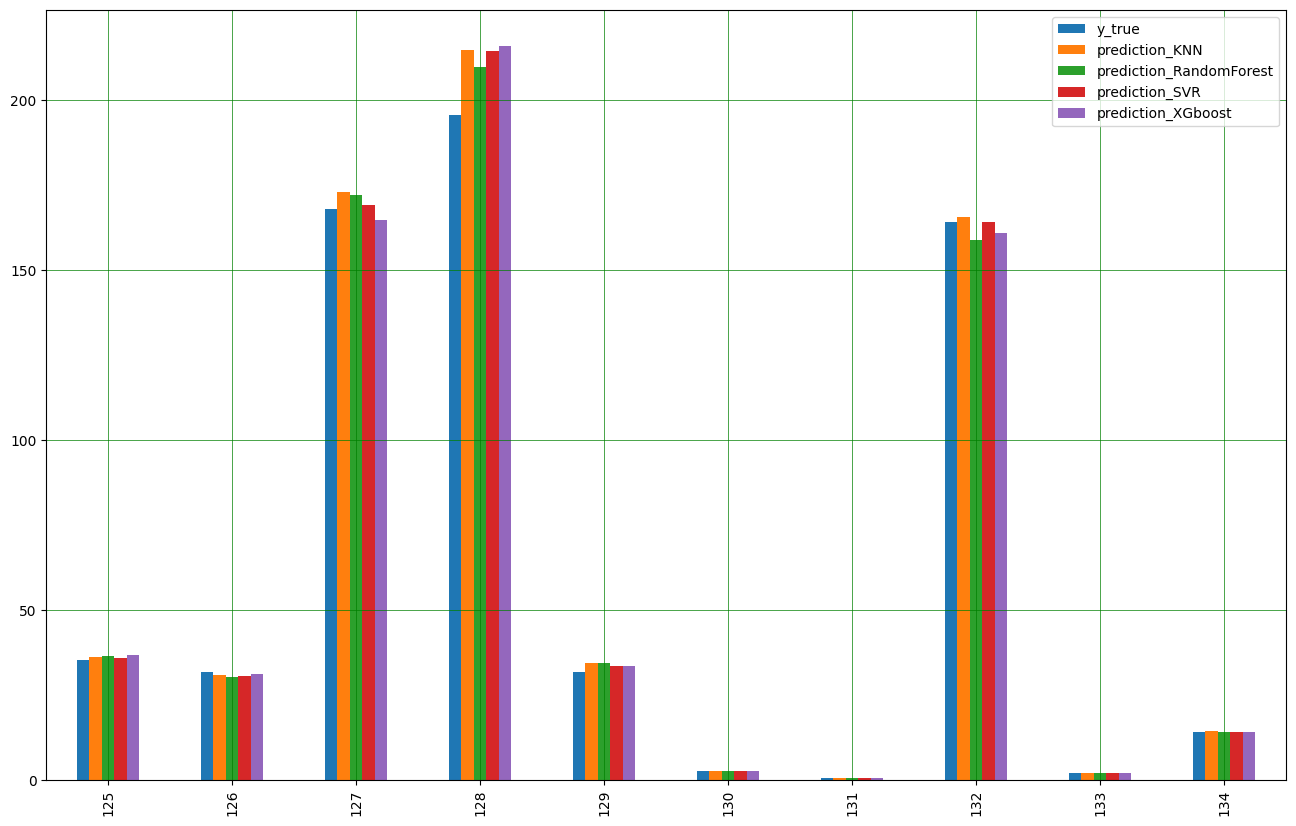

In [172]:
predictions = predictions.tail(10)
predictions.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()